In [43]:
import numpy as np
import pickle

In [44]:
with open('./train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

with open('./test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)    

In [45]:
len(train_data), len(test_data)

(10000, 1000)

In [46]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [47]:
story = ' '.join(train_data[0][0]) 
q = ' '.join(train_data[0][1])
ans = train_data[0][2]
print(story, q, ans, sep = '\n')

Mary moved to the bathroom . Sandra journeyed to the bedroom .
Is Sandra in the hallway ?
no


In [48]:
all_data = train_data + test_data

In [49]:
len(all_data)

11000

In [50]:
vocab = set()
for story, q, ans in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(q))

In [51]:
vocab.add('no')
vocab.add('yes')

In [52]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [53]:
vocab_len = len(vocab) + 1

In [54]:
print(vocab_len)

38


In [55]:
all_story_lens = [len(data[0]) for data in all_data]

In [56]:
max_story_len = max(all_story_lens)
print(max_story_len)

156


In [57]:
max_question_len = max([len(data[1]) for data in all_data])
print(max_question_len)

6


In [58]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

In [59]:
tokenzier = Tokenizer(filters = [])

In [60]:
tokenzier.fit_on_texts(vocab)

In [61]:
tokenzier.word_index

{'in': 1,
 'bedroom': 2,
 'back': 3,
 'put': 4,
 'up': 5,
 'there': 6,
 'apple': 7,
 'left': 8,
 'yes': 9,
 'moved': 10,
 'journeyed': 11,
 'football': 12,
 'got': 13,
 'dropped': 14,
 'no': 15,
 'john': 16,
 'bathroom': 17,
 'the': 18,
 '?': 19,
 'mary': 20,
 '.': 21,
 'travelled': 22,
 'office': 23,
 'picked': 24,
 'down': 25,
 'sandra': 26,
 'kitchen': 27,
 'milk': 28,
 'to': 29,
 'went': 30,
 'grabbed': 31,
 'discarded': 32,
 'took': 33,
 'is': 34,
 'garden': 35,
 'hallway': 36,
 'daniel': 37}

In [62]:
train_story_text = []
train_question_text = []
train_answer_text = []

for story, q, ans in train_data:
    train_story_text.append(story)
    train_question_text.append(q)
    train_answer_text.append(ans)

In [63]:
train_story_seq = tokenzier.texts_to_sequences(train_story_text)
print(len(train_story_seq))

10000


In [70]:
def vectorize_stories(data, word_index = tokenzier.word_index, max_story_len = max_story_len, max_question_len = max_question_len):
    X = []
    Xq = []
    Y = []
    
    for story, question, ans in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        y = np.zeros(len(word_index) + 1)
        y[word_index[ans]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    return pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen = max_question_len), np.array(Y)

In [71]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [80]:
np.sum(answers_train, axis = 0)

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       5012.,    0.,    0.,    0.,    0.,    0., 4988.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

In [111]:
from keras.models import Sequential, Model

In [112]:
from keras.layers import Embedding

In [113]:
from keras.layers import Dense, Activation, Dropout, Input, add, concatenate, LSTM, dot, Permute

In [114]:
input_sequence = Input(shape = (max_story_len, ))
question = Input(shape = (max_question_len, ))

In [115]:
vocab_size = len(vocab) + 1

In [116]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_size, output_dim = 64))
input_encoder_m.add(Dropout(0.3))

In [117]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_size, output_dim = max_question_len))
input_encoder_c.add(Dropout(0.3))

In [118]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_question_len))
question_encoder.add(Dropout(0.3))

In [119]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [120]:
match = dot([input_encoded_m, question_encoded], axes = (2,2))
match = Activation('softmax')(match)

In [121]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [122]:
answer = concatenate([response, question_encoded])

In [123]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [124]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)

In [125]:
answer = Dense(units = vocab_size)(answer)

In [126]:
answer = Activation('softmax')(answer)

In [128]:
model = Model([input_sequence, question], answer)

In [129]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [130]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, None, 64)     2432        ['input_3[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 6, 64)        2432        ['input_4[0][0]']                
                                                                                              

In [131]:
hist = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=100, validation_data=([inputs_test,queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 17s 22ms/step - loss: 0.8812 - accuracy: 0.4932 - val_loss: 0.6940 - val_accuracy: 0.4970
Epoch 2/100
313/313 [==============================] - 6s 20ms/step - loss: 0.7013 - accuracy: 0.5081 - val_loss: 0.6952 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6959 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6942 - accuracy: 0.5078 - val_loss: 0.6949 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6948 - accuracy: 0.5035 - val_loss: 0.6954 - val_accuracy: 0.4970
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6948 - accuracy: 0.4961 - val_loss: 0.6950 - val_accuracy: 0.4970
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6945 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy

313/313 [==============================] - 6s 18ms/step - loss: 0.2990 - accuracy: 0.8726 - val_loss: 0.3721 - val_accuracy: 0.8280
Epoch 58/100
313/313 [==============================] - 6s 20ms/step - loss: 0.2975 - accuracy: 0.8732 - val_loss: 0.3717 - val_accuracy: 0.8300
Epoch 59/100
313/313 [==============================] - 5s 18ms/step - loss: 0.2971 - accuracy: 0.8753 - val_loss: 0.3903 - val_accuracy: 0.8270
Epoch 60/100
313/313 [==============================] - 6s 18ms/step - loss: 0.2968 - accuracy: 0.8735 - val_loss: 0.3667 - val_accuracy: 0.8250
Epoch 61/100
313/313 [==============================] - 6s 19ms/step - loss: 0.2956 - accuracy: 0.8742 - val_loss: 0.3572 - val_accuracy: 0.8280
Epoch 62/100
313/313 [==============================] - 6s 20ms/step - loss: 0.2917 - accuracy: 0.8735 - val_loss: 0.3876 - val_accuracy: 0.8290
Epoch 63/100
313/313 [==============================] - 6s 19ms/step - loss: 0.2943 - accuracy: 0.8740 - val_loss: 0.3833 - val_accuracy: 0.825

In [132]:
model.save('model.h5')

In [134]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [135]:
import matplotlib.pyplot as plt

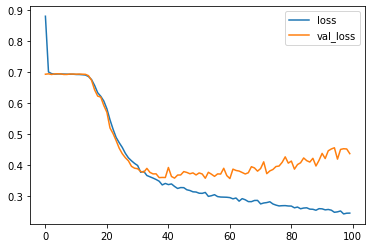

In [138]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

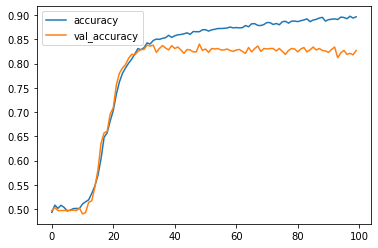

In [139]:
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')
plt.show()

In [140]:
pred_results = model.predict([inputs_test, queries_test])

32/32 [==============================] - 3s 8ms/step


In [143]:
pred_idx = pred_results.argmax(axis = 1)

In [147]:
pred_outputs = [tokenzier.index_word[idx] for idx in pred_idx]

In [149]:
model.evaluate([inputs_test, queries_test], answers_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.4375 - accuracy: 0.8270


[0.4375338554382324, 0.8270000219345093]

In [150]:
for i in range(len(pred_outputs)):
    print('pred: ', pred_outputs[i], ' , actual: ', test_data[i][2])

pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  no
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  ye

pred:  no  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pre

pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  no
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  no
pred:  no  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred:  no  , actual:  yes
pred:  no  , actual:  no
pred:  no  , actual:  no
pred:  yes  , actual:  yes
pred:  yes  , actual:  yes
pred

In [158]:
my_story = 'John left the kitchen . Sandra dropped football in the garden .'
my_question = 'Is football in the garden ?'
my_data = [(my_story.split(), my_question.split(), 'yes')]

In [160]:
story_seq, question_seq, asnwer_seq = vectorize_stories(my_data)

In [166]:
print('Predicted: ', tokenzier.index_word.get(model.predict([story_seq, question_seq]).argmax(axis = 1)[0]))

1/1 [==============================] - 0s 40ms/step
Predicted:  yes
